## 01. Imports & Dataset Upload

In [ ]:
import os
import json
import hashlib
import joblib
import warnings
import logging

from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_optuna

from typing import List, Dict

from lightgbm import Dataset as lgbDataset
from lightgbm import early_stopping, log_evaluation

from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor

# Setup
warnings.filterwarnings("ignore")
np.random.seed(42)
RANDOM_STATE = 42

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

ASSET_TYPE = "property"
DATA_PATH = "data/df_cleaned_no_outliers.csv"
MODEL_BASE_DIR = "../models"

ASSET_CONFIG = {
    "property": {
        "target": "valuation_k",
        "categorical": [
            "location", "energy_class", "has_elevator", "has_garden",
            "has_balcony", "garage", "owner_occupied", "public_transport_nearby"
        ],
        "numeric": [
            "size_m2", "rooms", "bathrooms", "year_built", "floor", "building_floors",
            "humidity_level", "temperature_avg", "noise_level", "air_quality_index",
            "luxury_score", "env_score", "distance_to_center_km", "valuation_k",
            "last_verified_ts"
        ],
        "exclude": [
            "asset_id", "asset_type", "condition_score", "risk_score",
            "prediction_ts", "age_years", "age_category", "luxury_category", "value_segment", "timestamp"
        ],
    },
    "art": {"target": "valuation_k", "categorical": [], "numeric": [], "exclude": []},
}

assert ASSET_TYPE in ASSET_CONFIG, f"Unknown asset_type: {ASSET_TYPE}"
cfg = ASSET_CONFIG[ASSET_TYPE]

## 02. Load Dataset

In [210]:
df = pd.read_csv(DATA_PATH)
logging.info(f"📥 Loaded dataset: {DATA_PATH} | Shape: {df.shape}")

2025-07-28 20:01:35,228 [INFO] 📥 Loaded dataset: ../data/df_cleaned_no_outliers.csv | Shape: (4920, 44)


In [211]:
# Ensure important engineered features are present
logging.info("⚙️ Ensuring required engineered features...")

if "age_years" not in df.columns and "year_built" in df.columns:
    current_year = datetime.utcnow().year
    df["age_years"] = current_year - df["year_built"]

if "price_per_sqm" not in df.columns:
    df["price_per_sqm"] = df["valuation_k"] * 1000 / df["size_m2"]

if "luxury_score" not in df.columns:
    df["luxury_score"] = (df["has_garden"] + df["has_balcony"] + df["garage"]) / 3

if "efficiency_score" not in df.columns:
    df["efficiency_score"] = (
        (df["valuation_k"] / df["size_m2"]) * (1 + df["luxury_score"])
    )

df = df.drop(columns=["efficiency_score", "price_per_sqm"], errors="ignore")

2025-07-28 20:01:35,486 [INFO] ⚙️ Ensuring required engineered features...


## 03. Normalization / Derivations

In [212]:
# Anno corrente per derivare età immobile
current_year = datetime.utcnow().year

# Correzione naming colonne se necessario
if "year_build" in df.columns and "year_built" not in df.columns:
    df = df.rename(columns={"year_build": "year_built"})

# Calcolo età se mancante
if "age_years" not in df.columns and "year_built" in df.columns:
    df["age_years"] = current_year - df["year_built"]

# Aggiungila alle feature numeriche se presente
if "age_years" in df.columns and "age_years" not in cfg["numeric"]:
    cfg["numeric"].append("age_years")

# Pulizia finale delle colonne exclude
df = df.drop(columns=[col for col in cfg["exclude"] if col in df.columns])

if "year_built" in df.columns:
    current_year = datetime.utcnow().year
    df["age_years"] = current_year - df["year_built"]

logging.info(f"✅ Dataset ready | Shape: {df.shape}")
df.head()

2025-07-28 20:01:36,282 [INFO] ✅ Dataset ready | Shape: (4920, 37)


,location,region,urban_type,size_m2,rooms,bathrooms,year_built,floor,building_floors,has_elevator,...,rooms_per_sqm,bathrooms_per_room,avg_room_size,location_premium,amenity_count,price_vs_region_avg,size_bin,anomaly_score,anomaly_flag,age_years
0,Trieste,northeast,semiurban,125,6,3,2015,3,5,1,...,0.048000,0.500000,20.833333,1.0,3,0.564057,"(119.5, 135.4]",1,False,10
1,Verona,north,semiurban,107,2,1,1955,3,9,1,...,0.018692,0.500000,53.500000,1.0,2,1.122689,"(103.6, 119.5]",1,False,70
2,Turin,north,urban,57,2,1,1997,3,9,1,...,0.035088,0.500000,28.500000,1.2,1,0.426079,"(55.9, 71.8]",1,False,28
3,Padua,north,semiurban,151,5,3,1972,1,2,0,...,0.033113,0.600000,30.200000,1.0,3,1.825467,"(135.4, 151.3]",1,False,53
4,Bari,south,semiurban,60,3,2,1976,4,9,1,...,0.050000,0.666667,20.000000,1.0,3,0.306557,"(55.9, 71.8]",1,False,49


## 04. Sanity checks

In [213]:
# Verifica che tutte le colonne richieste siano presenti
required_base = list(set([cfg["target"]] + cfg["categorical"] + cfg["numeric"]))
missing = [col for col in required_base if col not in df.columns]
if missing:
    raise ValueError(f"❌ Missing required columns: {missing}")

# Rimozione duplicati eventuali
cfg["categorical"] = sorted(set(cfg["categorical"]))
cfg["numeric"] = sorted(set(cfg["numeric"]))

# Filtro automatico delle feature non presenti nel dataset
cfg["numeric"] = [col for col in cfg["numeric"] if col in df.columns]
cfg["categorical"] = [col for col in cfg["categorical"] if col in df.columns]

# Determina le colonne usabili come feature
excluded = set(cfg["exclude"] + [cfg["target"]])
feature_candidates = [col for col in df.columns if col not in excluded]

# Logging dettagliato
logging.info("📊 FEATURE SELECTION OVERVIEW")
logging.info(f"🎯 Target: {cfg['target']}")
logging.info(f"🧩 Categorical: {cfg['categorical']}")
logging.info(f"📐 Numeric: {cfg['numeric']}")
logging.info(f"🚫 Excluded: {cfg['exclude']}")
logging.info(f"✅ Feature pool: {feature_candidates}")

2025-07-28 20:01:37,108 [INFO] 📊 FEATURE SELECTION OVERVIEW
2025-07-28 20:01:37,109 [INFO] 🎯 Target: valuation_k
2025-07-28 20:01:37,110 [INFO] 🧩 Categorical: ['energy_class', 'garage', 'has_balcony', 'has_elevator', 'has_garden', 'location', 'owner_occupied', 'public_transport_nearby']
2025-07-28 20:01:37,110 [INFO] 📐 Numeric: ['age_years', 'air_quality_index', 'bathrooms', 'building_floors', 'distance_to_center_km', 'env_score', 'floor', 'humidity_level', 'last_verified_ts', 'luxury_score', 'noise_level', 'rooms', 'size_m2', 'temperature_avg', 'valuation_k', 'year_built']
2025-07-28 20:01:37,111 [INFO] 🚫 Excluded: ['asset_id', 'asset_type', 'condition_score', 'risk_score', 'prediction_ts', 'age_years', 'age_category', 'luxury_category', 'value_segment', 'timestamp']
2025-07-28 20:01:37,112 [INFO] ✅ Feature pool: ['location', 'region', 'urban_type', 'size_m2', 'rooms', 'bathrooms', 'year_built', 'floor', 'building_floors', 'has_elevator', 'has_garden', 'has_balcony', 'garage', 'owner_

## 05. Overfitting check

In [214]:
def comprehensive_overfitting_check(pipeline, X_train, X_test, y_train, y_test):
    """
    Analisi completa dell'overfitting tramite MAE su training, test e cross-validation.
    """
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1  # 🔁 sfrutta il parallelismo
    )
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    logging.info("\n🔍 OVERFITTING ANALYSIS")
    logging.info("=" * 50)
    logging.info(f"Training MAE: {train_mae:.2f}")
    logging.info(f"CV MAE:       {cv_mae:.2f} ± {cv_std:.2f}")
    logging.info(f"Test MAE:     {test_mae:.2f}")

    if train_mae < cv_mae * 0.5:
        logging.warning("❌ SEVERE OVERFITTING: Train MAE << CV MAE")
    if test_mae > cv_mae * 2:
        logging.warning("❌ POOR GENERALIZATION: Test MAE >> CV MAE")

    return {"train": train_mae, "cv": cv_mae, "test": test_mae}

## 06. Final feature list = categorical + numeric

In [215]:
feature_list = cfg["categorical"] + cfg["numeric"]
logging.info(f"🧮 Final feature list: {feature_list}")

X = df[feature_list].copy()
y = df[cfg["target"]].copy()

2025-07-28 20:01:39,900 [INFO] 🧮 Final feature list: ['energy_class', 'garage', 'has_balcony', 'has_elevator', 'has_garden', 'location', 'owner_occupied', 'public_transport_nearby', 'age_years', 'air_quality_index', 'bathrooms', 'building_floors', 'distance_to_center_km', 'env_score', 'floor', 'humidity_level', 'last_verified_ts', 'luxury_score', 'noise_level', 'rooms', 'size_m2', 'temperature_avg', 'valuation_k', 'year_built']


## 07. Train/test split

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

# Allineamento categorie
for col in X_train.select_dtypes(include="object").columns:
    all_categories = pd.Series(pd.concat([X_train[col], X_test[col]])).astype("category").cat.categories
    X_train[col] = X_train[col].astype("category").cat.set_categories(all_categories)
    X_test[col] = X_test[col].astype("category").cat.set_categories(all_categories)

## 08. Preprocessing + Tuning

In [217]:
df['last_verified_ts']
df['location'], df['energy_class']

(0        Trieste
 1         Verona
 2          Turin
 3          Padua
 4           Bari
           ...   
 4915       Turin
 4916       Milan
 4917    Florence
 4918     Bologna
 4919        Bari
 Name: location, Length: 4920, dtype: object,
 0       C
 1       G
 2       F
 3       C
 4       B
        ..
 4915    D
 4916    D
 4917    F
 4918    C
 4919    E
 Name: energy_class, Length: 4920, dtype: object)

In [225]:
df['location_energy_class'] = (
    df['location'].astype(str) + "_" + df['energy_class'].astype(str)
)

feature_cols = [c for c in df.columns 
                if c not in ['valuation_k', 'asset_id', 'timestamp',
                             'last_verified_ts', 'location_energy_class']]

X_full = df[feature_cols]
y_full = df['valuation_k']

In [ ]:
# --- 1) Verifica e filtro colonne per il preprocessing ---
missing_cat = [c for c in cfg["categorical"] if c not in X_full.columns]
missing_num = [c for c in cfg["numeric"]     if c not in X_full.columns]
if missing_cat or missing_num:
    logging.warning(f"Colonne mancanti → categorical: {missing_cat}, numeric: {missing_num}")

categorical_cols = [c for c in cfg["categorical"] if c in X_full.columns]
numeric_cols     = [c for c in cfg["numeric"]     if c in X_full.columns]
assert categorical_cols or numeric_cols, "⚠️ Nessuna colonna valida per preprocessing!"

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num", "passthrough",                                         numeric_cols),
])

# --- 2) TimeSeriesSplit sul timestamp ---
tscv = TimeSeriesSplit(n_splits=5)
train_idx, valid_idx = next(tscv.split(X_full, df["last_verified_ts"]))
X_tune, X_valid = X_full.iloc[train_idx],  X_full.iloc[valid_idx]
y_tune, y_valid = y_full.iloc[train_idx], y_full.iloc[valid_idx]
logging.info(f"[TS] Fold0 → Train: {X_tune.shape}, Valid: {X_valid.shape}")

# --- 3) Fit & transform features ---
X_tune_enc  = preprocessor.fit_transform(X_tune)
X_valid_enc = preprocessor.transform(X_valid)

assert X_tune_enc.shape[0] == y_tune.shape[0],  "Shape mismatch on training data"
assert X_valid_enc.shape[0] == y_valid.shape[0], "Shape mismatch on validation data"
logging.info(f"🧩 Preprocessed shapes → Tune: {X_tune_enc.shape}, Valid: {X_valid_enc.shape}")

# --- 4) Costruzione dataset LightGBM (log1p target) ---
dtrain = lgb.Dataset(data=X_tune_enc,  label=np.log1p(y_tune))
dvalid = lgb.Dataset(data=X_valid_enc, label=np.log1p(y_valid))

# --- 5) Parametri ottimizzati e training ---
best_min_child = 25
lgb_params = {
    "objective":        "regression",
    "metric":           "mae",
    "boosting_type":    "gbdt",
    "verbosity":        -1,
    "seed":             RANDOM_STATE,
    "num_leaves":       50,
    "max_depth":        8,
    "min_data_in_leaf": 50,
    "min_split_gain":   0.1,
    "min_child_samples": best_min_child,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq":     5,
    "reg_alpha":        0.1,
    "reg_lambda":       0.1,
    "max_bin":          255,
    "force_col_wise":   True
}
learning_rate = 0.01

best_model = study.best_trial.user_attrs["best_model"]
n_estimators = best_model.best_estimator_.get_params()["n_estimators"]

optuna_result_ts = lgb_optuna.train(
    params={**lgb_params, "learning_rate": learning_rate},
    train_set=dtrain,
    valid_sets=[dvalid],
    num_boost_round=n_estimators,
    callbacks=[
        early_stopping(stopping_rounds=50, first_metric_only=True),
        log_evaluation(period=25),
    ],
)

# --- 6) Log risultati TimeSeriesSplit ---
best_iter_ts = optuna_result_ts.best_iteration
best_mae_ts  = optuna_result_ts.best_score["valid_0"]["l1"]
logging.info(f"✅ TS best_min_child_samples: {best_min_child}")
logging.info(f"✅ TS best_iteration: {best_iter_ts}")
logging.info(f"📉 TS Best MAE (log1p): {best_mae_ts:.4f}")

2025-07-28 21:39:10,783 [WARNING] Colonne mancanti → categorical: [], numeric: ['last_verified_ts', 'valuation_k']
2025-07-28 21:39:10,787 [INFO] [TS] Fold0 → Train: (820, 35), Valid: (820, 35)
2025-07-28 21:39:10,807 [INFO] 🧩 Preprocessed shapes → Tune: (820, 48), Valid: (820, 48)
[I 2025-07-28 21:39:10,811] A new study created in memory with name: no-name-d5c29775-a88e-4352-99d0-64a8dd36bf68
feature_fraction, val_score: 0.244829:  14%|######4                                      | 1/7 [00:00<00:00,  7.36it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.353027
[50]	valid_0's l1: 0.311049
[75]	valid_0's l1: 0.283554
[100]	valid_0's l1: 0.266778
[125]	valid_0's l1: 0.256613
[150]	valid_0's l1: 0.251026
[175]	valid_0's l1: 0.248292
[200]	valid_0's l1: 0.246555
[225]	valid_0's l1: 0.245715
[250]	valid_0's l1: 0.24503
[275]	valid_0's l1: 0.244829
[300]	valid_0's l1: 0.24516
[325]	valid_0's l1: 0.24539
Early stopping, best iteration is:
[275]	valid_0's l1: 0.244829
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.370695
[50]	valid_0's l1: 0.336793
[75]	valid_0's l1: 0.312506
[100]	valid_0's l1: 0.295138
[125]	valid_0's l1: 0.278257
[150]	valid_0's l1: 0.269316
[175]	valid_0's l1: 0.260592


feature_fraction, val_score: 0.244094:  29%|############8                                | 2/7 [00:00<00:00,  6.54it/s]

[200]	valid_0's l1: 0.254982
[225]	valid_0's l1: 0.251402
[250]	valid_0's l1: 0.248942
[275]	valid_0's l1: 0.247288
[300]	valid_0's l1: 0.246127
[325]	valid_0's l1: 0.244895
[350]	valid_0's l1: 0.244211
[375]	valid_0's l1: 0.244113
[400]	valid_0's l1: 0.244261
[425]	valid_0's l1: 0.244498
Early stopping, best iteration is:
[380]	valid_0's l1: 0.244094
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.374579
[50]	valid_0's l1: 0.343097
[75]	valid_0's l1: 0.319039
[100]	valid_0's l1: 0.305216
[125]	valid_0's l1: 0.286167
[150]	valid_0's l1: 0.27714
[175]	valid_0's l1: 0.267874
[200]	valid_0's l1: 0.260879
[225]	valid_0's l1: 0.256736
[250]	valid_0's l1: 0.253374
[275]	valid_0's l1: 0.250971
[300]	valid_0's l1: 0.248876
[325]	valid_0's l1: 0.247193
[350]	valid_0's l1: 0.246194
[375]	valid_0's l1: 0.245598


feature_fraction, val_score: 0.244041:  57%|#########################7                   | 4/7 [00:00<00:00,  7.63it/s]

[400]	valid_0's l1: 0.245487
[425]	valid_0's l1: 0.245191
[450]	valid_0's l1: 0.245291
Early stopping, best iteration is:
[417]	valid_0's l1: 0.245116
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.382018
[50]	valid_0's l1: 0.356476
[75]	valid_0's l1: 0.33218
[100]	valid_0's l1: 0.320006
[125]	valid_0's l1: 0.303259
[150]	valid_0's l1: 0.292634
[175]	valid_0's l1: 0.282552
[200]	valid_0's l1: 0.27

feature_fraction, val_score: 0.244041:  71%|################################1            | 5/7 [00:00<00:00,  7.14it/s]

[275]	valid_0's l1: 0.259327
[300]	valid_0's l1: 0.255153
[325]	valid_0's l1: 0.252617
[350]	valid_0's l1: 0.250738
[375]	valid_0's l1: 0.249428
[400]	valid_0's l1: 0.248847
[425]	valid_0's l1: 0.247868
[450]	valid_0's l1: 0.247442
[475]	valid_0's l1: 0.246983
[500]	valid_0's l1: 0.246295
Did not meet early stopping. Best iteration is:
[517]	valid_0's l1: 0.246107
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.352994
[50]	valid_0's l1: 0.314578
[75]	valid_0's l1: 0.287288
[100]	valid_0's l1: 0.269481
[125]	valid_0's l1: 0.258359
[150]	valid_0's l1: 0.252347
[175]	valid_0's l1: 0.248625
[200]	valid_0's l1: 0.246618
[225]	valid_0's l1: 0.245427
[250]	valid_0's l1: 0.244549
[275]	valid_0's l1: 0.244398
[300]	valid_0's l1: 0.244621


feature_fraction, val_score: 0.244041: 100%|#############################################| 7/7 [00:00<00:00,  7.11it/s]


[325]	valid_0's l1: 0.244726
Early stopping, best iteration is:
[283]	valid_0's l1: 0.244391
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.359669
[50]	valid_0's l1: 0.323186
[75]	valid_0's l1: 0.29295
[100]	valid_0's l1: 0.276874
[125]	valid_0's l1: 0.26382
[150]	valid_0's l1: 0.256007
[175]	valid_0's l1: 0.2507
[200]	valid_0's l1: 0.247407
[225]	valid_0's l1: 0.245764
[250]	valid_0's l1: 0.244837
[275]	valid_0's l1: 0.244426
[300]	valid_0's l1: 0.244243
[325]	valid_0's l1: 0.244169
[350]	valid_0's l1: 0.244448
[375]	valid_0's l1: 0.244817
Early stopping, best iteration is:
[325]	valid_0's l1: 0.244169
Evaluated only: l1


num_leaves, val_score: 0.244041:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.244041:   5%|##5                                               | 1/20 [00:00<00:02,  7.00it/s]

[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931


num_leaves, val_score: 0.244041:  10%|#####                                             | 2/20 [00:00<00:02,  6.92it/s]

[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411


num_leaves, val_score: 0.244041:  20%|##########                                        | 4/20 [00:00<00:02,  7.32it/s]

Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362158
[50]	valid_0's l1: 0.325023
[75]	valid_0's l1: 0.296859
[100]	valid_0's l1: 0.281178
[125]	valid_0's l1: 0.268051
[150]	valid_0's l1: 0.260504
[175]	valid_0's l1: 0.253812
[200]	valid_0's l1: 0.249672
[225]	valid_0's l1: 0.247306
[250]	valid_0's l1: 0.245736
[275]	valid_0's l1: 0.244896
[300]	valid_0's l1: 0.244336
[325]	valid_0's l1: 0.244084
[350]	valid_0's l1: 0.244145
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244084
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706


num_leaves, val_score: 0.244041:  30%|###############                                   | 6/20 [00:00<00:01,  8.17it/s]

[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788


num_leaves, val_score: 0.244041:  35%|#################5                                | 7/20 [00:00<00:01,  7.61it/s]

[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659


num_leaves, val_score: 0.244041:  40%|####################                              | 8/20 [00:01<00:01,  7.25it/s]

[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1


num_leaves, val_score: 0.244041:  50%|########################5                        | 10/20 [00:01<00:01,  7.03it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511


num_leaves, val_score: 0.244041:  55%|##########################9                      | 11/20 [00:01<00:01,  6.99it/s]

[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1


num_leaves, val_score: 0.244041:  65%|###############################8                 | 13/20 [00:01<00:00,  7.19it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816


num_leaves, val_score: 0.244041:  75%|####################################7            | 15/20 [00:02<00:00,  7.38it/s]

[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998


num_leaves, val_score: 0.244041:  80%|#######################################2         | 16/20 [00:02<00:00,  7.02it/s]

[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706


num_leaves, val_score: 0.244041:  85%|#########################################6       | 17/20 [00:02<00:00,  7.01it/s]

[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1


num_leaves, val_score: 0.244041:  95%|##############################################5  | 19/20 [00:02<00:00,  6.90it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511
[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362155
[50]	valid_0's l1: 0.324998
[75]	valid_0's l1: 0.296788
[100]	valid_0's l1: 0.281051
[125]	valid_0's l1: 0.267931
[150]	valid_0's l1: 0.260511


num_leaves, val_score: 0.244041: 100%|#################################################| 20/20 [00:02<00:00,  7.14it/s]


[175]	valid_0's l1: 0.253766
[200]	valid_0's l1: 0.249706
[225]	valid_0's l1: 0.247266
[250]	valid_0's l1: 0.245659
[275]	valid_0's l1: 0.244816
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244043
[350]	valid_0's l1: 0.24411
Early stopping, best iteration is:
[323]	valid_0's l1: 0.244041
Evaluated only: l1


bagging, val_score: 0.244041:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.36123
[50]	valid_0's l1: 0.324462
[75]	valid_0's l1: 0.296229
[100]	valid_0's l1: 0.280121
[125]	valid_0's l1: 0.267703


bagging, val_score: 0.243962:  10%|#####3                                               | 1/10 [00:00<00:02,  3.12it/s]

[150]	valid_0's l1: 0.260071
[175]	valid_0's l1: 0.253347
[200]	valid_0's l1: 0.248775
[225]	valid_0's l1: 0.246567
[250]	valid_0's l1: 0.245529
[275]	valid_0's l1: 0.244737
[300]	valid_0's l1: 0.244129
[325]	valid_0's l1: 0.244071
[350]	valid_0's l1: 0.244044
Early stopping, best iteration is:
[309]	valid_0's l1: 0.243962
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.361629
[50]	valid_0's l1: 0.324914
[75]	valid_0's l1: 0.296412
[100]	valid_0's l1: 0.280677
[125]	valid_0's l1: 0.268098
[150]	valid_0's l1: 0.260671
[175]	valid_0's l1: 0.253913
[200]	valid_0's l1: 0.249543
[225]	valid_0's l1: 0.247339
[250]	valid_0's l1: 0.246228
[275]	valid_0's l1: 0.245557
[300]	valid_0's l1: 0.245142
[325]	valid_0's l1: 0.244717
[350]	valid_0's l1: 0.244549
[375]	valid_0's l1: 0.244546
[400]	valid_0's l1: 0.244572
Early stopping, best iteration is:
[364]	valid_0's l1: 0.244495
Evaluated only: l1


bagging, val_score: 0.243962:  20%|##########6                                          | 2/10 [00:00<00:01,  4.48it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.361668
[50]	valid_0's l1: 0.325379
[75]	valid_0's l1: 0.296721
[100]	valid_0's l1: 0.280898
[125]	valid_0's l1: 0.267927
[150]	valid_0's l1: 0.260545
[175]	valid_0's l1: 0.253909
[200]	valid_0's l1: 0.249259
[225]	valid_0's l1: 0.246895
[250]	valid_0's l1: 0.245606
[275]	valid_0's l1: 0.244778
[300]	valid_0's l1: 0.244418
[325]	valid_0's l1: 0.244325


bagging, val_score: 0.243962:  30%|###############9                                     | 3/10 [00:00<00:01,  5.28it/s]

[350]	valid_0's l1: 0.244328
Early stopping, best iteration is:
[309]	valid_0's l1: 0.244228
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362156
[50]	valid_0's l1: 0.324807
[75]	valid_0's l1: 0.297967
[100]	valid_0's l1: 0.282571
[125]	valid_0's l1: 0.270275
[150]	valid_0's l1: 0.263322
[175]	valid_0's l1: 0.256363
[200]	valid_0's l1: 0.251823
[225]	valid_0's l1: 0.249224


bagging, val_score: 0.243962:  40%|#####################2                               | 4/10 [00:00<00:01,  5.93it/s]

[250]	valid_0's l1: 0.247725
[275]	valid_0's l1: 0.246686
[300]	valid_0's l1: 0.245847
[325]	valid_0's l1: 0.245281
[350]	valid_0's l1: 0.245143
[375]	valid_0's l1: 0.244899
[400]	valid_0's l1: 0.244722
[425]	valid_0's l1: 0.24472
[450]	valid_0's l1: 0.245292
Early stopping, best iteration is:
[413]	valid_0's l1: 0.244664
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.36159
[50]	valid_0's l1: 0.324862
[75]	valid_0's l1: 0.296821
[100]	valid_0's l1: 0.281191
[125]	valid_0's l1: 0.268595
[150]	valid_0's l1: 0.261249
[175]	valid_0's l1: 0.254475
[200]	valid_0's l1: 0.249887
[225]	valid_0's l1: 0.247632
[250]	valid_0's l1: 0.246362
[275]	valid_0's l1: 0.245396
[300]	valid_0's l1: 0.244737
[325]	valid_0's l1: 0.244493
[350]	valid_0's l1: 0.244503
[375]	valid_0's l1: 0.244537
Early stopping, best iteration is:
[342]	valid_0's l1: 0.244224
Evaluated only: l1


bagging, val_score: 0.243962:  50%|##########################5                          | 5/10 [00:00<00:00,  6.19it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.361613
[50]	valid_0's l1: 0.325002
[75]	valid_0's l1: 0.296452
[100]	valid_0's l1: 0.280635
[125]	valid_0's l1: 0.267826
[150]	valid_0's l1: 0.260183
[175]	valid_0's l1: 0.253399
[200]	valid_0's l1: 0.249259
[225]	valid_0's l1: 0.246931
[250]	valid_0's l1: 0.245838
[275]	valid_0's l1: 0.245041


bagging, val_score: 0.243962:  60%|###############################8                     | 6/10 [00:01<00:00,  6.14it/s]

[300]	valid_0's l1: 0.244574
[325]	valid_0's l1: 0.24442
[350]	valid_0's l1: 0.244346
[375]	valid_0's l1: 0.244473
[400]	valid_0's l1: 0.244481
Early stopping, best iteration is:
[353]	valid_0's l1: 0.244345
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.361915
[50]	valid_0's l1: 0.325029
[75]	valid_0's l1: 0.296783
[100]	valid_0's l1: 0.281077
[125]	valid_0's l1: 0.268454


bagging, val_score: 0.243828:  70%|#####################################                | 7/10 [00:01<00:00,  6.64it/s]

[150]	valid_0's l1: 0.261065
[175]	valid_0's l1: 0.254541
[200]	valid_0's l1: 0.250164
[225]	valid_0's l1: 0.247757
[250]	valid_0's l1: 0.246245
[275]	valid_0's l1: 0.245129
[300]	valid_0's l1: 0.2444
[325]	valid_0's l1: 0.244086
[350]	valid_0's l1: 0.243915
[375]	valid_0's l1: 0.244208
Early stopping, best iteration is:
[340]	valid_0's l1: 0.243828
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.36157
[50]	valid_0's l1: 0.32462
[75]	valid_0's l1: 0.296369
[100]	valid_0's l1: 0.281107


bagging, val_score: 0.243828:  80%|##########################################4          | 8/10 [00:01<00:00,  7.22it/s]

[125]	valid_0's l1: 0.268275
[150]	valid_0's l1: 0.260761
[175]	valid_0's l1: 0.254422
[200]	valid_0's l1: 0.250257
[225]	valid_0's l1: 0.24818
[250]	valid_0's l1: 0.246586
[275]	valid_0's l1: 0.245308
[300]	valid_0's l1: 0.244954
[325]	valid_0's l1: 0.2451
[350]	valid_0's l1: 0.245005
Early stopping, best iteration is:
[308]	valid_0's l1: 0.244789
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362267
[50]	valid_0's l1: 0.325604


bagging, val_score: 0.243101:  80%|##########################################4          | 8/10 [00:01<00:00,  7.22it/s]

[75]	valid_0's l1: 0.297505
[100]	valid_0's l1: 0.283136
[125]	valid_0's l1: 0.26954
[150]	valid_0's l1: 0.261993
[175]	valid_0's l1: 0.255457
[200]	valid_0's l1: 0.251042
[225]	valid_0's l1: 0.247576
[250]	valid_0's l1: 0.246173
[275]	valid_0's l1: 0.245098
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244051
[350]	valid_0's l1: 0.243382
[375]	valid_0's l1: 0.243208
[400]	valid_0's l1: 0.243109
[425]	valid_0's l1: 0.243545
Early stopping, best iteration is:
[380]	valid_0's l1: 0.243101
Evaluated only: l1


bagging, val_score: 0.243101:  90%|###############################################7     | 9/10 [00:01<00:00,  7.46it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362348
[50]	valid_0's l1: 0.325356
[75]	valid_0's l1: 0.2974
[100]	valid_0's l1: 0.282861
[125]	valid_0's l1: 0.269522
[150]	valid_0's l1: 0.261875
[175]	valid_0's l1: 0.25528
[200]	valid_0's l1: 0.251164
[225]	valid_0's l1: 0.247956
[250]	valid_0's l1: 0.246439
[275]	valid_0's l1: 0.245356
[300]	valid_0's l1: 0.244425
[325]	valid_0's l1: 0.244042
[350]	valid_0's l1: 0.243571
[375]	valid_0's l1: 0.243418
[400]	valid_0's l1: 0.243217


bagging, val_score: 0.243101: 100%|####################################################| 10/10 [00:01<00:00,  6.31it/s]


[425]	valid_0's l1: 0.243274
[450]	valid_0's l1: 0.243604
Early stopping, best iteration is:
[400]	valid_0's l1: 0.243217
Evaluated only: l1


feature_fraction_stage2, val_score: 0.243101:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.36231
[50]	valid_0's l1: 0.325666
[75]	valid_0's l1: 0.295789
[100]	valid_0's l1: 0.280574
[125]	valid_0's l1: 0.267423
[150]	valid_0's l1: 0.260135
[175]	valid_0's l1: 0.254307
[200]	valid_0's l1: 0.250081
[225]	valid_0's l1: 0.246896
[250]	valid_0's l1: 0.245735


feature_fraction_stage2, val_score: 0.243101:  17%|######3                               | 1/6 [00:00<00:00,  7.88it/s]

[275]	valid_0's l1: 0.244821
[300]	valid_0's l1: 0.244234
[325]	valid_0's l1: 0.244192
[350]	valid_0's l1: 0.243627
[375]	valid_0's l1: 0.243496
[400]	valid_0's l1: 0.243486
[425]	valid_0's l1: 0.243712
Early stopping, best iteration is:
[380]	valid_0's l1: 0.243425
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.368078
[50]	valid_0's l1: 0.331102
[75]	valid_0's l1: 0.306727
[100]	valid_0's l1: 0.290816
[125]	valid_0's l1: 0.275224
[150]	valid_0's l1: 0.267253
[175]	valid_0's l1: 0.259929
[200]	valid_0's l1: 0.253814
[225]	valid_0's l1: 0.249807
[250]	valid_0's l1: 0.248272
[275]	valid_0's l1: 0.246753
[300]	valid_0's l1: 0.245461


feature_fraction_stage2, val_score: 0.243007:  17%|######3                               | 1/6 [00:00<00:00,  7.88it/s]

[325]	valid_0's l1: 0.244548
[350]	valid_0's l1: 0.24367
[375]	valid_0's l1: 0.243243
[400]	valid_0's l1: 0.243007
[425]	valid_0's l1: 0.243256
[450]	valid_0's l1: 0.24346
Early stopping, best iteration is:
[400]	valid_0's l1: 0.243007
Evaluated only: l1


feature_fraction_stage2, val_score: 0.243007:  33%|############6                         | 2/6 [00:00<00:00,  7.06it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.359884
[50]	valid_0's l1: 0.323937
[75]	valid_0's l1: 0.293754
[100]	valid_0's l1: 0.279108
[125]	valid_0's l1: 0.266089
[150]	valid_0's l1: 0.258726
[175]	valid_0's l1: 0.252977
[200]	valid_0's l1: 0.249169
[225]	valid_0's l1: 0.246241
[250]	valid_0's l1: 0.245352
[275]	valid_0's l1: 0.244568
[300]	valid_0's l1: 0.244086
[325]	valid_0's l1: 0.244049


feature_fraction_stage2, val_score: 0.243007:  33%|############6                         | 2/6 [00:00<00:00,  7.06it/s]

[350]	valid_0's l1: 0.243748
[375]	valid_0's l1: 0.243473
[400]	valid_0's l1: 0.243367
[425]	valid_0's l1: 0.243672
[450]	valid_0's l1: 0.244128
Early stopping, best iteration is:
[400]	valid_0's l1: 0.243367
Evaluated only: l1


feature_fraction_stage2, val_score: 0.243007:  50%|###################                   | 3/6 [00:00<00:00,  7.17it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.368574
[50]	valid_0's l1: 0.333881
[75]	valid_0's l1: 0.310332
[100]	valid_0's l1: 0.293564
[125]	valid_0's l1: 0.277008
[150]	valid_0's l1: 0.268565
[175]	valid_0's l1: 0.260851
[200]	valid_0's l1: 0.254652
[225]	valid_0's l1: 0.250615
[250]	valid_0's l1: 0.24882
[275]	valid_0's l1: 0.247094
[300]	valid_0's l1: 0.245737


feature_fraction_stage2, val_score: 0.243007:  67%|#########################3            | 4/6 [00:00<00:00,  7.35it/s]

[325]	valid_0's l1: 0.24459
[350]	valid_0's l1: 0.243694
[375]	valid_0's l1: 0.243247
[400]	valid_0's l1: 0.243026
[425]	valid_0's l1: 0.243271
[450]	valid_0's l1: 0.243369
Early stopping, best iteration is:
[400]	valid_0's l1: 0.243026
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.366166
[50]	valid_0's l1: 0.329699
[75]	valid_0's l1: 0.301305
[100]	valid_0's l1: 0.286779
[125]	valid_0's l1: 0.272475
[150]	valid_0's l1: 0.264391
[175]	valid_0's l1: 0.257086

feature_fraction_stage2, val_score: 0.242910:  83%|###############################6      | 5/6 [00:00<00:00,  7.51it/s]


[200]	valid_0's l1: 0.25207
[225]	valid_0's l1: 0.248351
[250]	valid_0's l1: 0.246772
[275]	valid_0's l1: 0.24559
[300]	valid_0's l1: 0.244687
[325]	valid_0's l1: 0.244134
[350]	valid_0's l1: 0.243305
[375]	valid_0's l1: 0.243026
[400]	valid_0's l1: 0.242978
[425]	valid_0's l1: 0.243228
Early stopping, best iteration is:
[380]	valid_0's l1: 0.24291
Evaluated only: l1


[I 2025-07-28 21:39:16,891] Trial 41 finished with value: 0.24291020182667225 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 41 with value: 0.24291020182667225.
feature_fraction_stage2, val_score: 0.242910: 100%|######################################| 6/6 [00:00<00:00,  7.94it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.362267
[50]	valid_0's l1: 0.325604
[75]	valid_0's l1: 0.297505
[100]	valid_0's l1: 0.283136
[125]	valid_0's l1: 0.26954
[150]	valid_0's l1: 0.261993
[175]	valid_0's l1: 0.255457
[200]	valid_0's l1: 0.251042
[225]	valid_0's l1: 0.247576
[250]	valid_0's l1: 0.246173
[275]	valid_0's l1: 0.245098
[300]	valid_0's l1: 0.244323
[325]	valid_0's l1: 0.244051
[350]	valid_0's l1: 0.243382
[375]	valid_0's l1: 0.243208
[400]	valid_0's l1: 0.243109
[425]	valid_0's l1: 0.243545
Early stopping, best iteration is:
[380]	valid_0's l1: 0.243101
Evaluated only: l1


[I 2025-07-28 21:39:17,003] Trial 42 finished with value: 0.24310099727305673 and parameters: {'feature_fraction': 0.716}. Best is trial 41 with value: 0.24291020182667225.
regularization_factors, val_score: 0.242910:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243748


regularization_factors, val_score: 0.242623:   5%|#9                                    | 1/20 [00:00<00:02,  9.18it/s]

[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243748
[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1


regularization_factors, val_score: 0.242623:  10%|###8                                  | 2/20 [00:00<00:02,  8.33it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635


regularization_factors, val_score: 0.242616:  15%|#####7                                | 3/20 [00:00<00:02,  7.36it/s]

[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316


regularization_factors, val_score: 0.242616:  20%|#######6                              | 4/20 [00:00<00:02,  6.68it/s]

[325]	valid_0's l1: 0.243748
[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807


regularization_factors, val_score: 0.242616:  20%|#######6                              | 4/20 [00:00<00:02,  6.68it/s]

[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243748
[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1


regularization_factors, val_score: 0.242616:  25%|#########5                            | 5/20 [00:00<00:02,  6.82it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243748
[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1


regularization_factors, val_score: 0.242616:  30%|###########4                          | 6/20 [00:00<00:02,  6.69it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086


regularization_factors, val_score: 0.242616:  35%|#############3                        | 7/20 [00:01<00:01,  6.64it/s]

[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243748
[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086


regularization_factors, val_score: 0.242616:  35%|#############3                        | 7/20 [00:01<00:01,  6.64it/s]

[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243748
[350]	valid_0's l1: 0.242985
[375]	valid_0's l1: 0.242727
[400]	valid_0's l1: 0.242706
[425]	valid_0's l1: 0.242983
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242623
Evaluated only: l1


regularization_factors, val_score: 0.242616:  40%|###############2                      | 8/20 [00:01<00:01,  6.99it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427


regularization_factors, val_score: 0.242616:  45%|#################1                    | 9/20 [00:01<00:01,  6.87it/s]

[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1


regularization_factors, val_score: 0.242616:  50%|##################5                  | 10/20 [00:01<00:01,  6.64it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225


regularization_factors, val_score: 0.242616:  55%|####################3                | 11/20 [00:01<00:01,  6.47it/s]

[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889


regularization_factors, val_score: 0.242616:  55%|####################3                | 11/20 [00:01<00:01,  6.47it/s]

[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1


regularization_factors, val_score: 0.242616:  60%|######################2              | 12/20 [00:01<00:01,  6.67it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977


regularization_factors, val_score: 0.242616:  65%|########################             | 13/20 [00:01<00:01,  6.80it/s]

[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807


regularization_factors, val_score: 0.242616:  70%|#########################9           | 14/20 [00:02<00:00,  6.90it/s]

[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1


regularization_factors, val_score: 0.242616:  70%|#########################9           | 14/20 [00:02<00:00,  6.90it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1


regularization_factors, val_score: 0.242616:  75%|###########################7         | 15/20 [00:02<00:00,  6.99it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807


regularization_factors, val_score: 0.242616:  80%|#############################6       | 16/20 [00:02<00:00,  7.31it/s]

[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977


regularization_factors, val_score: 0.242616:  85%|###############################4     | 17/20 [00:02<00:00,  7.81it/s]

[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758


regularization_factors, val_score: 0.242616:  90%|#################################3   | 18/20 [00:02<00:00,  8.28it/s]

[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807


regularization_factors, val_score: 0.242616:  90%|#################################3   | 18/20 [00:02<00:00,  8.28it/s]

[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1


regularization_factors, val_score: 0.242616:  95%|###################################1 | 19/20 [00:02<00:00,  7.96it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086
[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1


min_child_samples, val_score: 0.242616:   0%|                                                    | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365994
[50]	valid_0's l1: 0.329335
[75]	valid_0's l1: 0.300889
[100]	valid_0's l1: 0.28635
[125]	valid_0's l1: 0.272086


min_child_samples, val_score: 0.242616:  20%|########8                                   | 1/5 [00:00<00:00,  7.31it/s]

[150]	valid_0's l1: 0.264003
[175]	valid_0's l1: 0.256758
[200]	valid_0's l1: 0.251813
[225]	valid_0's l1: 0.24807
[250]	valid_0's l1: 0.246387
[275]	valid_0's l1: 0.245225
[300]	valid_0's l1: 0.244316
[325]	valid_0's l1: 0.243741
[350]	valid_0's l1: 0.242977
[375]	valid_0's l1: 0.24272
[400]	valid_0's l1: 0.2427
[425]	valid_0's l1: 0.242977
Early stopping, best iteration is:
[380]	valid_0's l1: 0.242616
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.370504
[50]	valid_0's l1: 0.336604
[75]	valid_0's l1: 0.310981
[100]	valid_0's l1: 0.296924
[125]	valid_0's l1: 0.282894
[150]	valid_0's l1: 0.274498
[175]	valid_0's l1: 0.267282
[200]	valid_0's l1: 0.262009
[225]	valid_0's l1: 0.258868
[250]	valid_0's l1: 0.257
[275]	valid_0's l1: 0.255571
[300]	valid_0's l1: 0.254543
[325]	valid_0's l1: 0.25353
[350]	valid_0's l1: 0.252914
[375]	valid_0's l1: 0.252555
[400]	valid_0's l1: 0.252241
[425]	valid_0's l1: 0.251996
[450]	valid_0's l1: 0.2520

min_child_samples, val_score: 0.242616:  20%|########8                                   | 1/5 [00:00<00:00,  7.31it/s]

[475]	valid_0's l1: 0.252202
Early stopping, best iteration is:
[442]	valid_0's l1: 0.251902
Evaluated only: l1


min_child_samples, val_score: 0.242616:  40%|#################6                          | 2/5 [00:00<00:00,  8.30it/s]

Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.364611
[50]	valid_0's l1: 0.327983
[75]	valid_0's l1: 0.300925
[100]	valid_0's l1: 0.2869
[125]	valid_0's l1: 0.274481
[150]	valid_0's l1: 0.267403
[175]	valid_0's l1: 0.261252
[200]	valid_0's l1: 0.256935
[225]	valid_0's l1: 0.254363


min_child_samples, val_score: 0.242616:  60%|##########################4                 | 3/5 [00:00<00:00,  4.99it/s]

[250]	valid_0's l1: 0.252869
[275]	valid_0's l1: 0.251818
[300]	valid_0's l1: 0.251067
[325]	valid_0's l1: 0.250686
[350]	valid_0's l1: 0.24967
[375]	valid_0's l1: 0.249227
[400]	valid_0's l1: 0.249172
[425]	valid_0's l1: 0.249281
Early stopping, best iteration is:
[385]	valid_0's l1: 0.249119
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.365039
[50]	valid_0's l1: 0.328189
[75]	valid_0's l1: 0.300119
[100]	valid_0's l1: 0.286531
[125]	valid_0's l1: 0.273111
[150]	valid_0's l1: 0.265613
[175]	valid_0's l1: 0.258869


min_child_samples, val_score: 0.242616:  80%|###################################2        | 4/5 [00:00<00:00,  5.04it/s]

[200]	valid_0's l1: 0.254444
[225]	valid_0's l1: 0.252096
[250]	valid_0's l1: 0.250802
[275]	valid_0's l1: 0.249326
[300]	valid_0's l1: 0.248495
[325]	valid_0's l1: 0.248054
[350]	valid_0's l1: 0.247512
[375]	valid_0's l1: 0.247374
[400]	valid_0's l1: 0.247335
[425]	valid_0's l1: 0.24771
Early stopping, best iteration is:
[381]	valid_0's l1: 0.247242
Evaluated only: l1
Training until validation scores don't improve for 50 rounds
[25]	valid_0's l1: 0.36515
[50]	valid_0's l1: 0.32759
[75]	valid_0's l1: 0.298506
[100]	valid_0's l1: 0.283826
[125]	valid_0's l1: 0.269943
[150]	valid_0's l1: 0.261376
[175]	valid_0's l1: 0.254249
[200]	valid_0's l1: 0.249835
[225]	valid_0's l1: 0.246937
[250]	valid_0's l1: 0.245485
[275]	valid_0's l1: 0.244176
[300]	valid_0's l1: 0.243539
[325]	valid_0's l1: 0.243456
[350]	valid_0's l1: 0.243084
[375]	valid_0's l1: 0.243092
[400]	valid_0's l1: 0.243043


min_child_samples, val_score: 0.242616: 100%|############################################| 5/5 [00:00<00:00,  5.69it/s]
2025-07-28 21:39:20,682 [INFO] ✅ TS best_min_child_samples: 25
2025-07-28 21:39:20,683 [INFO] ✅ TS best_iteration: 380
2025-07-28 21:39:20,684 [INFO] 📉 TS Best MAE (log1p): 0.2426


[425]	valid_0's l1: 0.243768
Early stopping, best iteration is:
[381]	valid_0's l1: 0.242943
Evaluated only: l1


In [243]:
inner_tscv = TimeSeriesSplit(n_splits=3)
param_grid = {"alpha": [0.01, 0.1, 1.0, 10.0]}

grid_meta = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=inner_tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    refit=True
)
grid_meta.fit(meta_X, meta_y)

best_alpha = grid_meta.best_params_["alpha"]
logging.info(f"🔍 Meta‑learner best alpha (nested CV): {best_alpha}")

# Ricrea e rifit del meta‑learner con il valore ottimale
meta_learner = Ridge(alpha=best_alpha, random_state=RANDOM_STATE)
meta_learner.fit(meta_X, meta_y)

2025-07-28 21:40:12,194 [INFO] 🔍 Meta‑learner best alpha (nested CV): 10.0


Ridge(alpha=10.0, random_state=42)

## 09. Build pipeline con target transformer

In [235]:
# ——————————————————————————
# 1) Recupero dei parametri ottimali
# ——————————————————————————
# Se hai uno study Optuna:
best_optuna_params = study.best_params.copy()

# Configurazione finale per LGBM
final_params = {
    **best_optuna_params,
    "objective":      "regression",
    "metric":         "mae",
    "boosting_type":  "gbdt",
    "verbosity":      -1,
    "force_col_wise": True,
    "random_state":   RANDOM_STATE,
    "n_jobs":         -1,
    # Assicuriamoci di usare il numero di iterazioni ottimale
    "n_estimators":   optuna_result_ts.best_iteration  
}

logging.info(f"🎯 Final LGBM params: {final_params}")

# ——————————————————————————
# 2) Inizializzazione regressore e pipeline
# ——————————————————————————
lgb_final = lgb.LGBMRegressor(**final_params)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", TransformedTargetRegressor(
        regressor=lgb_final,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

logging.info("✅ Pipeline with optimized LightGBM + log1p transformation ready.")

2025-07-28 20:57:37,702 [INFO] 🎯 Final LGBM params: {'num_leaves': 31, 'max_depth': 3, 'learning_rate': 0.06109026455769496, 'min_child_samples': 29, 'subsample': 0.603762452799066, 'colsample_bytree': 0.8037262775627338, 'reg_alpha': 0.9227945819548118, 'reg_lambda': 0.9643724454764872, 'objective': 'regression', 'metric': 'mae', 'boosting_type': 'gbdt', 'verbosity': -1, 'force_col_wise': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 362}
2025-07-28 20:57:37,711 [INFO] ✅ Pipeline with optimized LightGBM + log1p transformation ready.


## 10. Validazione + CV

In [237]:
def validate_training_data(X, y):
    assert isinstance(X, pd.DataFrame), "❌ X must be a pandas DataFrame"
    assert isinstance(y, (pd.Series, pd.DataFrame)), "❌ y must be a pandas Series or DataFrame"
    assert X.shape[0] == y.shape[0], "❌ Features and target misaligned"
    assert not X.isnull().values.any(), "❌ Missing values in X"
    assert not y.isnull().values.any(), "❌ Missing values in y"
    logging.info(f"✅ Training data validated | X: {X.shape}, y: {y.shape}")

# Applichiamo la validazione sul dataset intero
validate_training_data(X_full, y_full)

# ——————————————————————————
# 4) Cross‐validation con TimeSeriesSplit
# ——————————————————————————
tscv = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(
    pipeline,
    X_full,
    y_full,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1
)

# Ricordiamo che cross_val_score restituisce MAE negativo
cv_mae = -cv_scores.mean()
cv_std = cv_scores.std()

logging.info("🔁 CROSS-VALIDATION RESULTS (TimeSeriesSplit)")
logging.info(f"✅ MAE: {cv_mae:.2f} ± {cv_std:.2f} k€")

2025-07-28 20:58:04,851 [INFO] ✅ Training data validated | X: (4920, 35), y: (4920,)
2025-07-28 20:58:05,527 [INFO] 🔁 CROSS-VALIDATION RESULTS (TimeSeriesSplit)
2025-07-28 20:58:05,528 [INFO] ✅ MAE: 70.73 ± 2.35 k€


In [269]:
# --- Helper per Prediction Intervals con Quantile Regression ---
def train_quantile_models(X_train, y_train, preprocessor, quantiles=[0.1, 0.5, 0.9]):
    """
    Allena per ogni quantile un modello LightGBM con objective='quantile'.
    Restituisce un dict {q: pipeline_q}.
    """
    quantile_models = {}
    for q in quantiles:
        # Modello LGB con loss quantile
        model_q = lgb.LGBMRegressor(
            objective='quantile',
            alpha=q,
            n_estimators=best_params.get('n_estimators', optuna_result.best_iteration),
            **{k: best_params[k] for k in best_params if k not in ['objective','metric','n_estimators']}
        )
        pipeline_q = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', TransformedTargetRegressor(
                regressor=model_q,
                func=np.log1p,
                inverse_func=np.expm1
            ))
        ])
        pipeline_q.fit(X_train, y_train)
        quantile_models[q] = pipeline_q
    return quantile_models

def predict_with_intervals(quantile_models, X):
    """
    DataFrame con predizioni per ciascun quantile.
    """
    intervals = {}
    for q, model in quantile_models.items():
        intervals[f"q{int(q*100)}"] = model.predict(X)
    return pd.DataFrame(intervals, index=X.index)

In [278]:
# ——————————————————————————
# Blending Hold-Out Stacking con Nested CV sul meta-learner
# ——————————————————————————

import logging
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# 1) Split “A/B” per blending (80/20)
X_A, X_B, y_A, y_B = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)
logging.info(f"[Blending] TrainA: {X_A.shape}, TrainB (meta-train): {X_B.shape}")

# 2) Fit dei base learners su A
base_learners = {
    "lgb": TransformedTargetRegressor(
        regressor=lgb.LGBMRegressor(
            **best_optuna_params,
            n_estimators=optuna_result_ts.best_iteration,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        func=np.log1p, inverse_func=np.expm1
    ),
    "xgb": TransformedTargetRegressor(
        regressor=XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.01,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0
        ),
        func=np.log1p, inverse_func=np.expm1
    ),
    "ridge": TransformedTargetRegressor(
        regressor=Ridge(alpha=1.0, random_state=RANDOM_STATE),
        func=np.log1p, inverse_func=np.expm1
    )
}

for name, learner in base_learners.items():
    learner.fit(preprocessor.fit_transform(X_A), y_A)
    logging.info(f"    • Base learner {name} trained on A")

# 3) Creazione delle meta-features su B
meta_X = np.vstack([
    learner.predict(preprocessor.transform(X_B))
    for learner in base_learners.values()
]).T
meta_y = y_B

# 4) Nested CV per ottimizzare alpha del meta-learner
inner_tscv = TimeSeriesSplit(n_splits=3)
param_grid = {"alpha": [0.01, 0.1, 1.0, 10.0]}

grid_meta = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=inner_tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    refit=True
)
grid_meta.fit(meta_X, meta_y)
best_alpha = grid_meta.best_params_["alpha"]
logging.info(f"🔍 Meta-learner best alpha (nested CV): {best_alpha}")

# 5) Fit finale del meta-learner con alpha ottimale
meta_learner = Ridge(alpha=best_alpha, random_state=RANDOM_STATE)
meta_learner.fit(meta_X, meta_y)
logging.info("    • Meta-learner (Ridge) trained on meta-features")

# 6) Refit dei base learners su tutto il training set
for name, learner in base_learners.items():
    learner.fit(preprocessor.fit_transform(X_full), y_full)
    logging.info(f"🔄 Base learner {name} refit on full training data")

# 7) Funzione di predizione finale con blending
def blending_predict(X):
    X_enc = preprocessor.transform(X)
    base_preds = np.vstack([lm.predict(X_enc) for lm in base_learners.values()]).T
    return meta_learner.predict(base_preds)

# --- Prediction intervals sul test set ---
quantiles = [0.05, 0.5, 0.95]
quantile_models = train_quantile_models(X_train, y_train, preprocessor, quantiles=quantiles)
pred_intervals = predict_with_intervals(quantile_models, X_test)

interval_cols = [f"q{int(q*100)}" for q in quantiles]
lower_col, median_col, upper_col = interval_cols
logging.info(pred_intervals.head().to_string())

# Calcola la copertura
lower = pred_intervals[lower_col].to_numpy()
upper = pred_intervals[upper_col].to_numpy()
actual = y_test.to_numpy()

coverage = np.mean((actual >= lower) & (actual <= upper))
avg_width = np.mean(upper - lower)

logging.info(f"📊 Interval coverage: {coverage:.2%}")
logging.info(f"📊 Average interval width: {avg_width:.2f} k€")

# 8) Valutazione blending sul test set
y_pred_blend = blending_predict(X_test)
mae_blend    = mean_absolute_error(y_test, y_pred_blend)
rmse_blend   = np.sqrt(mean_squared_error(y_test, y_pred_blend))
r2_blend     = r2_score(y_test, y_pred_blend)

logging.info("📈 FINAL BLENDING EVALUATION ON TEST SET")
logging.info(f"📊 MAE:  {mae_blend:.2f} k€")
logging.info(f"📊 RMSE: {rmse_blend:.2f} k€")
logging.info(f"📊 R²:   {r2_blend:.2f}")

2025-07-28 23:46:31,498 [INFO] [Blending] TrainA: (3936, 35), TrainB (meta-train): (984, 35)
2025-07-28 23:46:31,701 [INFO]     • Base learner lgb trained on A
2025-07-28 23:46:32,529 [INFO]     • Base learner xgb trained on A
2025-07-28 23:46:32,554 [INFO]     • Base learner ridge trained on A
2025-07-28 23:46:32,631 [INFO] 🔍 Meta-learner best alpha (nested CV): 10.0
2025-07-28 23:46:32,634 [INFO]     • Meta-learner (Ridge) trained on meta-features
2025-07-28 23:46:32,856 [INFO] 🔄 Base learner lgb refit on full training data
2025-07-28 23:46:33,796 [INFO] 🔄 Base learner xgb refit on full training data
2025-07-28 23:46:33,821 [INFO] 🔄 Base learner ridge refit on full training data
2025-07-28 23:46:34,677 [INFO]               q5         q50         q95
373   105.913477  182.051433  250.678070
4916  262.430583  450.751867  644.828143
1550   72.238333  118.917330  169.482520
3081  145.291829  248.122928  340.581734
3857  208.879696  377.717571  533.801386
2025-07-28 23:46:34,678 [INFO] 📊 

## 12. Feature Importance

In [ ]:
# 🔍 FEATURE IMPORTANCE ANALYSIS (LightGBM base learner)
logging.info("🧠 Analyzing feature importances from the LGBM base learner in the blending model...")

# 1) Estrai i nomi delle feature dopo OneHotEncoder dal preprocessor
try:
    ohe = preprocessor.named_transformers_["cat"]
    encoded_cat = list(ohe.get_feature_names_out(categorical_cols))
except Exception as e:
    logging.error(f"❌ Errore estrazione OHE features: {e}")
    encoded_cat = []

# 2) Combina feature one-hot + numeriche
feature_names = encoded_cat + numeric_cols

# 3) Estrai il booster LightGBM dal base learner
lgb_booster = base_learners["lgb"].regressor_.booster_

# 4) Importanza delle feature per gain
gain_importances = lgb_booster.feature_importance(importance_type="gain")
feat_imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "gain_importance": gain_importances
    })
    .sort_values("gain_importance", ascending=False)
    .reset_index(drop=True)
)

# 5) Aggiungi la permutazione importances già calcolata (opzionale)
#    perm è il risultato di sklearn.inspection.permutation_importance
if 'perm' in globals():
    perm_df = pd.DataFrame({
        "feature": X_test.columns,
        "perm_importance": perm.importances_mean
    })
    feat_imp_df = feat_imp_df.merge(perm_df, on="feature", how="left")

# 6) Mostra le prime 10
logging.info("🏆 Top 10 features by gain importance (and permutation if available):")
display(feat_imp_df.head(10))

## 13. Aggregated Importance

2025-07-28 22:56:05,105 [INFO] 📊 Aggregated importance by categorical feature:


,aggregated_importance
energy_class,0.020154
location,0.017134
owner_occupied,0.004754
has_balcony,0.004497
garage,0.003899
has_garden,0.003182
public_transport_nearby,0.003079
has_elevator,0.001198


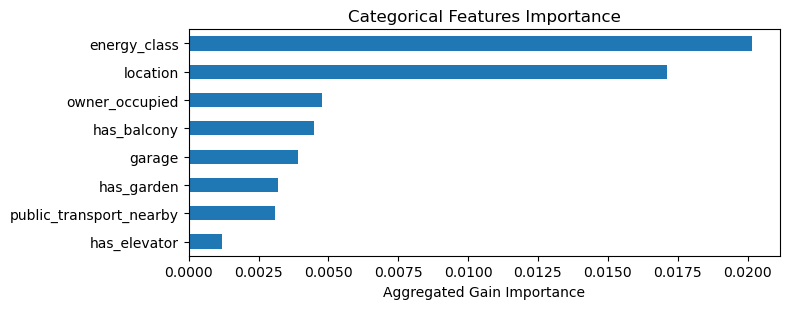

In [263]:
import re

def get_categorical_importance_summary(
    feat_importance: pd.DataFrame,
    categorical_cols: List[str],
    normalize: bool = False
) -> Dict[str, float]:
    """
    Calcola l'importanza aggregata per ogni colonna categorica originale
    (dopo one-hot encoding), sommando l'importanza delle variabili espanse.
    Se normalize=True, restituisce importanza media per dummy.
    """
    cat_importance: Dict[str, float] = {}
    for col in categorical_cols:
        # usa regex per match precisi inizio stringa
        pattern = re.compile(rf"^{re.escape(col)}_")
        sub_feats = [f for f in feat_importance["feature"] if pattern.match(f)]
        if not sub_feats:
            cat_importance[col] = 0.0
            continue
        total = feat_importance.loc[
            feat_importance["feature"].isin(sub_feats), "importance"
        ].sum()
        if normalize:
            total /= len(sub_feats)
        cat_importance[col] = total
    return cat_importance

# 1) Calcolo aggregated importance
cat_imp = get_categorical_importance_summary(
    feat_importance, categorical_cols, normalize=False
)
cat_importance_df = (
    pd.DataFrame.from_dict(cat_imp, orient="index", columns=["aggregated_importance"])
    .sort_values("aggregated_importance", ascending=False)
)

logging.info("📊 Aggregated importance by categorical feature:")
display(cat_importance_df)

# 2) (Opzionale) Unisci perm_importance se disponibile
if "perm" in globals():
    perm_df = pd.DataFrame({
        "feature": X_test.columns,
        "perm_importance": perm.importances_mean
    })
    # somma perm_importance per categoria
    cat_perm: Dict[str, float] = {}
    for col in categorical_cols:
        pattern = re.compile(rf"^{re.escape(col)}_")
        sub_feats = [f for f in perm_df["feature"] if pattern.match(f)]
        cat_perm[col] = perm_df.loc[
            perm_df["feature"].isin(sub_feats), "perm_importance"
        ].sum() if sub_feats else 0.0
    cat_importance_df["perm_importance"] = cat_importance_df.index.map(cat_perm)
    display(cat_importance_df)

# 3) Plot a barre orizzontali
plt.figure(figsize=(8, len(cat_importance_df) * 0.4))
cat_importance_df["aggregated_importance"].plot.barh()
plt.xlabel("Aggregated Gain Importance")
plt.title("Categorical Features Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 14. Save model & metadata

In [279]:
# === 1) Assicurati di aver già calcolato pred_intervals, coverage e avg_width ===
# pred_intervals = predict_with_intervals(quantile_models, X_test)
# lower = pred_intervals.iloc[:, 0].to_numpy()
# upper = pred_intervals.iloc[:, -1].to_numpy()
# actual = y_test.to_numpy()
# coverage = np.mean((actual >= lower) & (actual <= upper))
# avg_width = np.mean(upper - lower)

# === 2) Crea directory di destinazione se non esiste ===
os.makedirs(f"{MODEL_BASE_DIR}/{ASSET_TYPE}", exist_ok=True)

model_version = "v2"
model_name = f"value_regressor_{model_version}"

# === 3) Salvataggio modello ===
pipeline_filename = f"{MODEL_BASE_DIR}/{ASSET_TYPE}/{model_name}.joblib"
joblib.dump(pipeline, pipeline_filename)

# === 4) Calcolo hash dataset ===
with open(DATA_PATH, "rb") as f:
    dataset_hash = hashlib.sha256(f.read()).hexdigest()

# === 5) Feature encodate post-OHE ===
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cat_features = list(ohe.get_feature_names_out(categorical_cols))
encoded_feature_names = numeric_cols + encoded_cat_features

# === 6) Costruzione metadata ===
metadata = {
    "asset_type": ASSET_TYPE,
    "model_task": "valuation_regression",
    "model_version": model_version,
    "model_class": "TransformedTargetRegressor(LightGBM)",
    "random_state": RANDOM_STATE,
    "dataset_file": DATA_PATH,
    "dataset_hash_sha256": dataset_hash,
    "n_rows_total": len(df),
    "n_rows_train": len(X_train),
    "n_rows_test": len(X_test),
    "features_categorical": categorical_cols,
    "features_numeric": numeric_cols,
    "feature_list_ordered": feature_list,
    "features_encoded": encoded_feature_names,
    "encoded_feature_count": len(encoded_feature_names),
    "engineered_features": [
        "price_per_sqm",
        "luxury_score",
        "efficiency_score",
        "env_score",
        "age_years"
    ],
    "metrics": {
        "mae_k": round(mae, 4),
        "rmse_k": round(rmse, 4),
        "r2": round(r2, 4),
        "coverage_interval": round(coverage, 4),
        "avg_interval_width_k": round(avg_width, 4)
    },
    "prediction_intervals": {
        "quantiles": [0.05, 0.5, 0.95],
        "sample_intervals": pred_intervals.head(5).to_dict(orient="records")
    },
    "feature_importance_top10": feat_importance.head(10).to_dict(orient="records"),
    "best_params": best_params,
    "generated_at": datetime.utcnow().isoformat() + "Z",
}

# === 7) Statistiche su feature ingegnerizzate ===
engineered_features = [
    "price_per_sqm",
    "luxury_score",
    "efficiency_score",
    "env_score",
    "age_years"
]

metadata["engineered_feature_stats"] = {
    feat: {
        "mean": round(float(df[feat].mean()), 4),
        "min": round(float(df[feat].min()), 4),
        "max": round(float(df[feat].max()), 4),
    }
    for feat in engineered_features if feat in df.columns
}

# === 8) Salvataggio metadati ===
meta_filename = f"{MODEL_BASE_DIR}/{ASSET_TYPE}/{model_name}_meta.json"
with open(meta_filename, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

# === 9) Logging finale ===
logging.info(f"✅ Model saved → {pipeline_filename}")
logging.info(f"📄 Metadata saved → {meta_filename}")

2025-07-28 23:50:37,984 [INFO] ✅ Model saved → ../models/property/value_regressor_v2.joblib
2025-07-28 23:50:37,985 [INFO] 📄 Metadata saved → ../models/property/value_regressor_v2_meta.json


## TODO:

- Aggiungi versioning esplicito nei filename dei modelli
- Implementa health checks per monitorare drift
- Crea script wrapper per esecuzione automatizzata
- Aggiungi unit tests per funzioni critiche